In [1]:
from amrex2dask import AMReXDatasetMeta, AMReXFabsMetaSingleLevel, AMReXArray
import dask.array as da
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import xarray as xr

# Variables that are useful across levels

In [2]:
### Set up
## File paths
fname1 = 'UnstableABL1_farmrun1_noturbs'
fname2 = 'plt74000'
fplt = Path("/projects/awaken/lcheung/summit/", fname1+'/'+fname2)
outdir = Path('/projects/awaken/orybchuk/awaken-amrwind/analyze/yt/', fname1+'/'+fname2)
outdir.mkdir(exist_ok=True, parents=True)

In [3]:
### Read dataset header
dataset = AMReXDatasetMeta(fplt)

In [4]:
### Read metadata dataframes
df0 = pd.read_csv(Path(outdir, 'lev0_meta.csv'), index_col=0)
df1 = pd.read_csv(Path(outdir, 'lev1_meta.csv'), index_col=0)
df2 = pd.read_csv(Path(outdir, 'lev2_meta.csv'), index_col=0)
df3 = pd.read_csv(Path(outdir, 'lev3_meta.csv'), index_col=0)

In [5]:
### Directories to save out data
foutstore = Path('/scratch/orybchuk/awaken/awaken-amrwind/analysis/yt/', fname1+'/'+fname2)
foutstore.mkdir(exist_ok=True, parents=True)

foutstore0 = Path(foutstore, 'Level_0')
foutstore0.mkdir(exist_ok=True, parents=True)
foutstore1 = Path(foutstore, 'Level_1')
foutstore1.mkdir(exist_ok=True, parents=True)
foutstore2 = Path(foutstore, 'Level_2')
foutstore2.mkdir(exist_ok=True, parents=True)
foutstore3 = Path(foutstore, 'Level_3')
foutstore3.mkdir(exist_ok=True, parents=True)

savevars = ['temperature', 'tke', 'velocityx', 'velocityy', 'velocityz', 'velocity_meanx', 'velocity_meany', 'velocity_meanz']

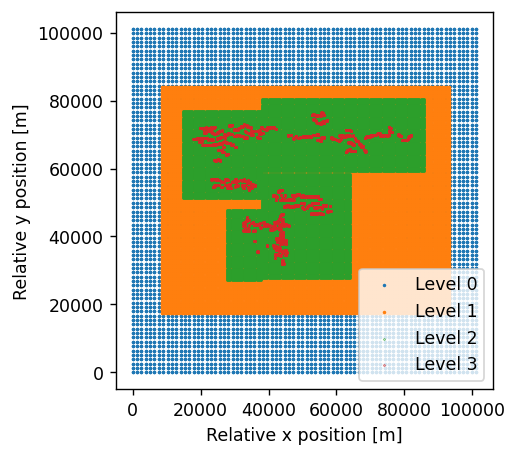

In [6]:
### Plot all Levels
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=125)

ax.scatter(20*df0['lo_i'], 20*df0['lo_j'], color='C0', label='Level 0', s=1)
ax.scatter(10*df1['lo_i'], 10*df1['lo_j'], color='C1', label='Level 1', s=1)
ax.scatter(5*df2['lo_i'], 5*df2['lo_j'], color='C2', label='Level 2', s=0.1)
ax.scatter(2.5*df3['lo_i'], 2.5*df3['lo_j'], color='C3', label='Level 3', s=0.1)


ax.legend()
ax.set_aspect('equal')

ax.set_xlabel("Relative x position [m]")
ax.set_ylabel("Relative y position [m]")

plt.show()

### Fab sizes

In [ ]:
# df0['di'].value_counts(), df0['dj'].value_counts(), df0['dk'].value_counts()

In [ ]:
# df1['di'].value_counts(), df1['dj'].value_counts(), df1['dk'].value_counts()

In [ ]:
# df2['di'].value_counts(), df2['dj'].value_counts(), df2['dk'].value_counts()

In [ ]:
# df3['di'].value_counts(), df3['dj'].value_counts(), df3['dk'].value_counts()

### Fab ordering

In [ ]:
df0[['lo_i', 'lo_j', 'lo_k']][:8]

In [ ]:
df1[['lo_i', 'lo_j', 'lo_k']][:8]

In [ ]:
df2[['lo_i', 'lo_j', 'lo_k']][:8]

In [ ]:
df3[['lo_i', 'lo_j', 'lo_k']][:9]

# Read into Dask and write to Zarr

## Level 0

In [ ]:
### Create a Dask array for each variable and save to Zarr
## Inputs
currlevel = 0
ilo0 = df0['lo_i'].min()
ihi0 = df0['hi_i'].max()
jlo0 = df0['lo_j'].min()
jhi0 = df0['hi_j'].max()
klo0 = df0['lo_k'].min()
khi0 = df0['hi_k'].max()
dx0, dy0, dz0 = dataset.dx[currlevel]

for fieldname in savevars:
    print(fieldname, datetime.now())
    
    arrout = AMReXArray(df0, dataset.fplt, 0, fieldname, dataset.field_list,
                      ilo0, ihi0, jlo0, jhi0, klo0, khi0, dx0, dy0, dz0)
    arrout.data.to_zarr(Path(foutstore0, f'{fieldname}.zarr'))

In [ ]:
### Merge all individual Level 0 variables into one store
## Load each store
ind_ds_list0 = []
for i, fieldname in enumerate(['temperature', 'tke', 'velocityx', 'velocityy', 'velocityz', 'velocity_meanx', 'velocity_meany', 'velocity_meanz']):
    fvar = Path(foutstore0, f'{fieldname}.zarr')
    ds = xr.open_zarr(fvar)
    ind_ds_list0.append(ds)
    
## Merge
ds_all0 = xr.merge(ind_ds_list0)

## Write out
print(datetime.now())
ds_all0.to_zarr(str(foutstore0)+'.zarr')
print(datetime.now())

## Level 2

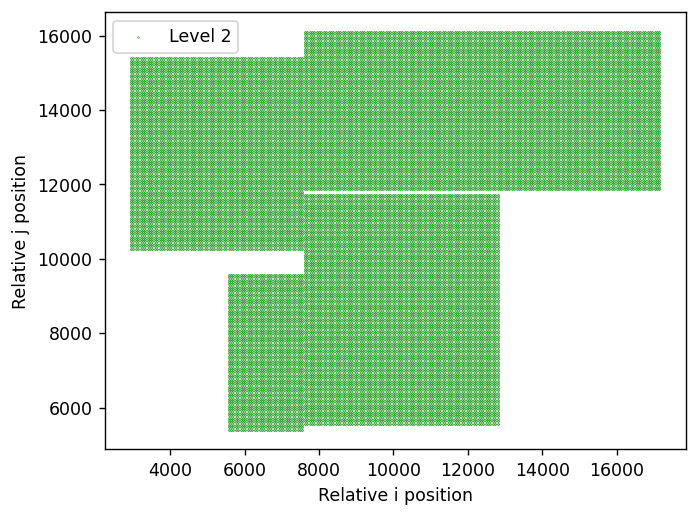

In [7]:
### Plot all Levels
fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=125)

ax.scatter(df2['lo_i'], df2['lo_j'], color='C2', label='Level 2', s=0.1)


# 
# ax.scatter(df2_tr_rough['lo_i'], df2_tr_rough['lo_j'], color='C3', label='TR', s=0.1)


ax.legend()
ax.set_aspect('equal')

# ax.set_ylim(11500, 12500)

ax.set_xlabel("Relative i position")
ax.set_ylabel("Relative j position")

plt.show()

In [8]:
### Manually identify the four different boxes in Level 2
## Lower left: AF
df2_af_rough = df2[df2['hi_j'] < 10000]
ilo_af = df2_af_rough['lo_i'].min()
jlo_af = df2_af_rough[df2_af_rough['lo_i']==ilo_af]['lo_j'].min()
jhi_af = df2_af_rough[df2_af_rough['lo_i']==ilo_af]['hi_j'].max()
ihi_af = df2_af_rough[df2_af_rough['lo_j']==jlo_af]['hi_i'].max()

## Lower right: KP
df2_kp_rough = df2[df2['hi_j'] < 11800]
ihi_kp = df2_kp_rough['hi_i'].max()
jlo_kp = df2_kp_rough[df2_kp_rough['hi_i']==ihi_kp]['lo_j'].min()
jhi_kp = df2_kp_rough[df2_kp_rough['hi_i']==ihi_kp]['hi_j'].max()
ilo_kp = df2_kp_rough[df2_kp_rough['hi_j']==jhi_kp]['lo_i'].min()

## Upper left: CV
df2_cv_rough = df2[df2['hi_j'] > 10000]
ilo_cv = df2_cv_rough['lo_i'].min()
jlo_cv = df2_cv_rough[df2_cv_rough['lo_i']==ilo_cv]['lo_j'].min()
jhi_cv = df2_cv_rough[df2_cv_rough['lo_i']==ilo_cv]['hi_j'].max()
ihi_cv = df2_cv_rough[df2_cv_rough['lo_j']==jlo_cv]['hi_i'].max()

## Upper right: TR
df2_tr_rough = df2_cv_rough
ihi_tr = df2_tr_rough['hi_i'].max()
jlo_tr = df2_tr_rough[df2_tr_rough['hi_i']==ihi_tr]['lo_j'].min()
jhi_tr = df2_tr_rough[df2_tr_rough['hi_i']==ihi_tr]['hi_j'].max()
ilo_tr = df2_tr_rough[df2_tr_rough['hi_j']==jhi_tr]['lo_i'].min()

In [9]:
### Create the dataframes for each subdomain
## Get unsorted df's
df2_af_uns = df2[(df2['lo_i'] >= ilo_af) &
                 (df2['hi_i'] <= ihi_af) &
                 (df2['lo_j'] >= jlo_af) &
                 (df2['hi_j'] <= jhi_af)]

df2_kp_uns = df2[(df2['lo_i'] >= ilo_kp) &
                 (df2['hi_i'] <= ihi_kp) &
                 (df2['lo_j'] >= jlo_kp) &
                 (df2['hi_j'] <= jhi_kp)]

df2_cv_uns = df2[(df2['lo_i'] >= ilo_cv) &
                 (df2['hi_i'] <= ihi_cv) &
                 (df2['lo_j'] >= jlo_cv) &
                 (df2['hi_j'] <= jhi_cv)]

df2_tr_uns = df2[(df2['lo_i'] >= ilo_tr) &
                 (df2['hi_i'] <= ihi_tr) &
                 (df2['lo_j'] >= jlo_tr) &
                 (df2['hi_j'] <= jhi_tr)]

## Calculate min/max k indices
klo_af = df2_af_uns['lo_k'].min()
khi_af = df2_af_uns['hi_k'].max()

klo_kp = df2_kp_uns['lo_k'].min()
khi_kp = df2_kp_uns['hi_k'].max()

klo_cv = df2_cv_uns['lo_k'].min()
khi_cv = df2_cv_uns['hi_k'].max()

klo_tr = df2_tr_uns['lo_k'].min()
khi_tr = df2_tr_uns['hi_k'].max()

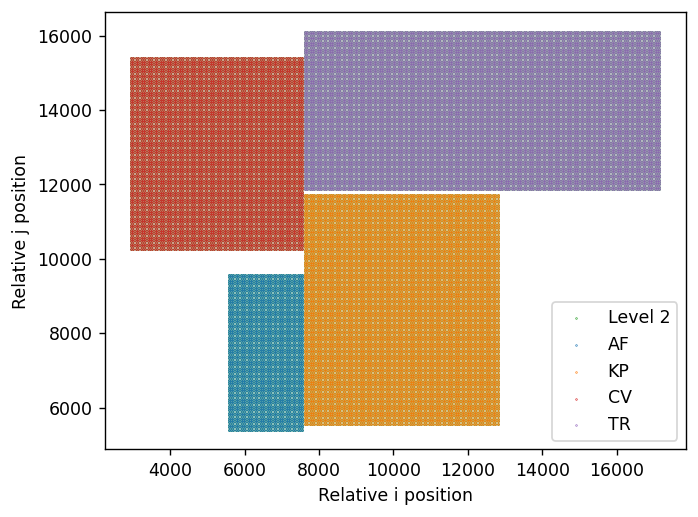

In [11]:
### Sanity check the sub domains
## Note: there will be a small offset between lines and dots on the high side because I'm plotting lo_i/j

fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=125)

ax.scatter(df2['lo_i'], df2['lo_j'], color='C2', label='Level 2', s=0.1)

## AF
ax.scatter(df2_af_uns['lo_i'], df2_af_uns['lo_j'], color='C0', label='AF', s=0.1)
# ax.set_xlim(ilo_af - 100, ihi_af + 100)
# ax.set_ylim(jlo_af - 100, jhi_af + 100)

## KP
ax.scatter(df2_kp_uns['lo_i'], df2_kp_uns['lo_j'], color='C1', label='KP', s=0.1)
# ax.set_xlim(ilo_kp - 100, ihi_kp + 100)
# ax.set_ylim(jlo_kp - 100, jhi_kp + 100)

## CV
ax.scatter(df2_cv_uns['lo_i'], df2_cv_uns['lo_j'], color='C3', label='CV', s=0.1)
# ax.set_xlim(ilo_cv - 100, ihi_cv + 100)
# ax.set_ylim(jlo_cv - 100, jhi_cv + 100)

## TR
ax.scatter(df2_tr_uns['lo_i'], df2_tr_uns['lo_j'], color='C4', label='TR', s=0.1)
# ax.plot([ilo_tr, ilo_tr], [jlo_tr, jhi_tr], color='C4', alpha=0.2)
# ax.plot([ihi_tr, ihi_tr], [jlo_tr, jhi_tr], color='C4', alpha=0.2)
# ax.plot([ilo_tr, ihi_tr], [jlo_tr, jlo_tr], color='C4', alpha=0.2)
# ax.plot([ilo_tr, ihi_tr], [jhi_tr, jhi_tr], color='C4', alpha=0.2)
# ax.set_xlim(ilo_tr - 100, ihi_tr + 100)
# ax.set_ylim(jlo_tr - 100, jhi_tr + 100)

ax.legend()
ax.set_aspect('equal')

ax.set_xlabel("Relative i position")
ax.set_ylabel("Relative j position")

plt.show()

### Check fab sizes


In [ ]:
df2_af_uns['di'].value_counts(), df2_af_uns['dj'].value_counts(), df2_af_uns['dk'].value_counts()

In [ ]:
df2_kp_uns['di'].value_counts(), df2_kp_uns['dj'].value_counts(), df2_kp_uns['dk'].value_counts()

In [ ]:
df2_cv_uns['di'].value_counts(), df2_cv_uns['dj'].value_counts(), df2_cv_uns['dk'].value_counts()

In [ ]:
df2_tr_uns['di'].value_counts(), df2_tr_uns['dj'].value_counts(), df2_tr_uns['dk'].value_counts()

### Continue with calculations

In [ ]:
### Create df's sorted as required by da.bloc()
##   Warning: brute force approach
## KP

# Calculate the (possibly varying) sizes of fabs
di_list_kp = list(df2_kp_uns['di'].value_counts().index)
dj_list_kp = list(df2_kp_uns['dj'].value_counts().index)
dk_list_kp = list(df2_kp_uns['dk'].value_counts().index)

di_list_kp.sort(reverse=True)
dj_list_kp.sort(reverse=True)
dk_list_kp.sort(reverse=True)

# ASSUME: the length of above lists is not longer than 2
assert len(di_list_kp) <= 2, "The number of unique di values must currently be no larger than 2!"
assert len(dj_list_kp) <= 2, "The number of unique dj values must currently be no larger than 2!"
assert len(dk_list_kp) <= 2, "The number of unique dk values must currently be no larger than 2!"

di_max = max(di_list_kp)
dj_max = max(dj_list_kp)
dk_max = max(dk_list_kp)
fabsize_max_kp = np.array((di_max, dj_max, dk_max))

# Calculate the number of fabs in each direction
# ASSUME: If there are multiple di/dj/dk values,
#   every fab aside from those one row/column
#   are the maximum di/dj/dk (TODO: generalize and check)
Li_kp = ihi_kp - ilo_kp
Lj_kp = jhi_kp - jlo_kp
Lk_kp = khi_kp - klo_kp

nfabblocks_kp = np.array((Li_kp, Lj_kp, Lk_kp)) / fabsize_max_kp
nfabblocks_kp = np.ceil(nfabblocks_kp).astype(int)

# Calculate the sorted indices
# NOTE: Under the above assumptions, the below code is the same for
#   constant and variable fab sizes
sorted_kp_inds = []
for k in range(nfabblocks_kp[2]):
    k_contrib = k*fabsize_max_kp[2] + klo_kp
    for j in range(nfabblocks_kp[1]):
        j_contrib = j*fabsize_max_kp[1] + jlo_kp
        for i in range(nfabblocks_kp[0]):
            i_contrib = i*fabsize_max_kp[0] + ilo_kp
            sorted_kp_inds.append([i_contrib, j_contrib, k_contrib])
sorted_kp_inds = np.array(sorted_kp_inds)

# Calculate the sorted dataframe in a brute force fashion
kp_sorted_rows = []
for fabind in range(len(sorted_kp_inds)):
    i_identifier = df2_kp_uns['lo_i'] == sorted_kp_inds[fabind][0]
    j_identifier = df2_kp_uns['lo_j'] == sorted_kp_inds[fabind][1]
    k_identifier = df2_kp_uns['lo_k'] == sorted_kp_inds[fabind][2]
    
    row = df2_kp_uns[i_identifier & j_identifier & k_identifier].copy()
    kp_sorted_rows.append(row)
df_kp_sorted = pd.concat(kp_sorted_rows)

In [ ]:
### Create Dask array using sorted dataframes
dx2, dy2, dz2 = dataset.dx[2]

for fieldname in savevars:
    print(fieldname, datetime.now())
    
    arrout = AMReXArray(df_kp_sorted, dataset.fplt, 2, fieldname, dataset.field_list,
                      ilo_kp, ihi_kp, jlo_kp, jhi_kp, klo_kp, khi_kp, dx2, dy2, dz2)
    arrout.data.to_zarr(Path(foutstore2, f'{fieldname}.zarr'))


In [ ]:
### Merge all individual Level 2 variables into one store
## Load each store
ind_ds_list2 = []
for i, fieldname in enumerate(['temperature', 'tke', 'velocityx', 'velocityy', 'velocityz', 'velocity_meanx', 'velocity_meany', 'velocity_meanz']):
    fvar = Path(foutstore2, f'{fieldname}.zarr')
    ds = xr.open_zarr(fvar)
    ind_ds_list2.append(ds)
    
## Merge
ds_all2 = xr.merge(ind_ds_list2)

## Write out
print(datetime.now())
ds_all2.to_zarr(str(foutstore2)+'_kp.zarr')
print(datetime.now())

## Level 3

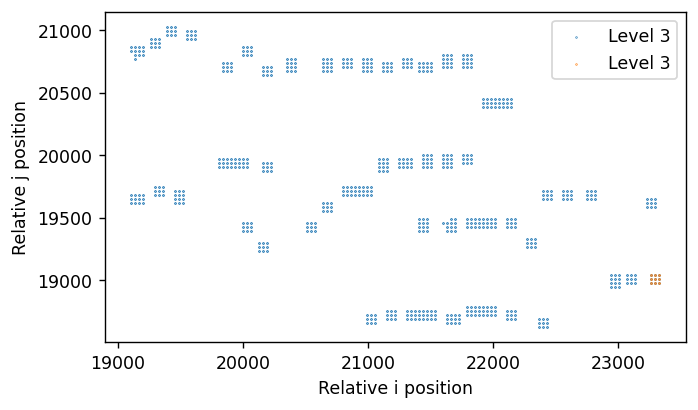

In [62]:
### Plot all Levels
fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=125)

# ax.scatter(df3['lo_i'], df3['lo_j'], color='C3', label='Level 3', s=0.1)


ax.scatter(df3_kp_rough['lo_i'], df3_kp_rough['lo_j'], color='C0', label='Level 3', s=0.1)

ax.scatter(df3_T0_uns['lo_i'], df3_T0_uns['lo_j'], color='C1', label='Level 3', s=0.1)


# 
# ax.scatter(df2_tr_rough['lo_i'], df2_tr_rough['lo_j'], color='C3', label='TR', s=0.1)


ax.legend()
ax.set_aspect('equal')

# ax.set_xlim(20000, 25000)
# ax.set_ylim(17500, 22500)

ax.set_xlabel("Relative i position")
ax.set_ylabel("Relative j position")

plt.show()

In [61]:
### Manually identify a few turbines, following my own nomenclature for now
## T0
df3_kp_rough = df3[(df3['hi_j'] < 22500) & (df3['lo_i'] > 19000)]

ihi_T0 = df3_kp_rough['hi_i'].max()
ilo_T0 = ihi_T0 - 3*32
jlo_T0 = df3_kp_rough[df3_kp_rough['hi_i']==ihi_T0]['lo_j'].min()
jhi_T0 = df3_kp_rough[df3_kp_rough['hi_i']==ihi_T0]['hi_j'].max()
# ilo_T0 = df3_kp_rough[df3_kp_rough['lo_j']==jlo_T0]['lo_i'].min()

df3_T0_uns = df3[(df3['lo_i'] >= ilo_T0) &
                 (df3['hi_i'] <= ihi_T0) &
                 (df3['lo_j'] >= jlo_T0) &
                 (df3['hi_j'] <= jhi_T0)]

klo_T0 = df3_T0_uns['lo_k'].min()
khi_T0 = df3_T0_uns['hi_k'].max()

In [68]:
### Create df's sorted as required by da.bloc()
##   Warning: brute force approach
## T0

# Calculate the (possibly varying) sizes of fabs
di_list_T0 = list(df3_T0_uns['di'].value_counts().index)
dj_list_T0 = list(df3_T0_uns['dj'].value_counts().index)
dk_list_T0 = list(df3_T0_uns['dk'].value_counts().index)

di_list_T0.sort(reverse=True)
dj_list_T0.sort(reverse=True)
dk_list_T0.sort(reverse=True)

# ASSUME: the length of above lists is not longer than 2
assert len(di_list_T0) <= 2, "The number of unique di values must currently be no larger than 2!"
assert len(dj_list_T0) <= 2, "The number of unique dj values must currently be no larger than 2!"
assert len(dk_list_T0) <= 2, "The number of unique dk values must currently be no larger than 2!"

di_max = max(di_list_T0)
dj_max = max(dj_list_T0)
dk_max = max(dk_list_T0)
fabsize_max_T0 = np.array((di_max, dj_max, dk_max))

# Calculate the number of fabs in each direction
# ASSUME: If there are multiple di/dj/dk values,
#   every fab aside from those one row/column
#   are the maximum di/dj/dk (TODO: generalize and check)
Li_T0 = ihi_T0 - ilo_T0
Lj_T0 = jhi_T0 - jlo_T0
Lk_T0 = khi_T0 - klo_T0

nfabblocks_T0 = np.array((Li_T0, Lj_T0, Lk_T0)) / fabsize_max_T0
nfabblocks_T0 = np.ceil(nfabblocks_T0).astype(int)

# Calculate the sorted indices
# NOTE: Under the above assumptions, the below code is the same for
#   constant and variable fab sizes
sorted_T0_inds = []
for k in range(nfabblocks_T0[2]):
    k_contrib = k*fabsize_max_T0[2] + klo_T0
    for j in range(nfabblocks_T0[1]):
        j_contrib = j*fabsize_max_T0[1] + jlo_T0
        for i in range(nfabblocks_T0[0]):
            i_contrib = i*fabsize_max_T0[0] + ilo_T0
            sorted_T0_inds.append([i_contrib, j_contrib, k_contrib])
sorted_T0_inds = np.array(sorted_T0_inds)

# Calculate the sorted dataframe in a brute force fashion
T0_sorted_rows = []
for fabind in range(len(sorted_T0_inds)):
    i_identifier = df3_T0_uns['lo_i'] == sorted_T0_inds[fabind][0]
    j_identifier = df3_T0_uns['lo_j'] == sorted_T0_inds[fabind][1]
    k_identifier = df3_T0_uns['lo_k'] == sorted_T0_inds[fabind][2]
    
    row = df3_T0_uns[i_identifier & j_identifier & k_identifier].copy()
    T0_sorted_rows.append(row)
df_T0_sorted = pd.concat(T0_sorted_rows)

In [71]:
### Create Dask array using sorted dataframes
dx3, dy3, dz3 = dataset.dx[3]

for fieldname in savevars:
    print(fieldname, datetime.now())
    
    arrout = AMReXArray(df_T0_sorted, dataset.fplt, 3, fieldname, dataset.field_list,
                      ilo_T0, ihi_T0, jlo_T0, jhi_T0, klo_T0, khi_T0, dx3, dy3, dz3)
    arrout.data.to_zarr(Path(foutstore3, f'{fieldname}.zarr'))

temperature 2023-03-08 10:28:21.128486
tke 2023-03-08 10:28:23.048099
velocityx 2023-03-08 10:28:23.118583
velocityy 2023-03-08 10:28:23.187461
velocityz 2023-03-08 10:28:23.254539
velocity_meanx 2023-03-08 10:28:23.322439
velocity_meany 2023-03-08 10:28:23.389008
velocity_meanz 2023-03-08 10:28:23.456688


In [72]:
### Merge all individual Level 2 variables into one store
## Load each store
ind_ds_list3 = []
for i, fieldname in enumerate(['temperature', 'tke', 'velocityx', 'velocityy', 'velocityz', 'velocity_meanx', 'velocity_meany', 'velocity_meanz']):
    fvar = Path(foutstore3, f'{fieldname}.zarr')
    ds = xr.open_zarr(fvar)
    ind_ds_list3.append(ds)
    
## Merge
ds_all3 = xr.merge(ind_ds_list3)

## Write out
print(datetime.now())
ds_all3.to_zarr(str(foutstore3)+'_T0.zarr')
print(datetime.now())

2023-03-08 10:28:51.747338
2023-03-08 10:28:52.558895


In [73]:
ds_all3

<xarray.Dataset>
Dimensions:         (x: 96, y: 96, z: 64)
Coordinates:
  * x               (x) float64 5.816e+04 5.816e+04 ... 5.84e+04 5.84e+04
  * y               (y) float64 4.744e+04 4.744e+04 ... 4.768e+04 4.768e+04
  * z               (z) float64 0.0 2.5 5.0 7.5 10.0 ... 150.0 152.5 155.0 157.5
Data variables:
    temperature     (x, y, z) float64 dask.array<chunksize=(32, 32, 32), meta=np.ndarray>
    tke             (x, y, z) float64 dask.array<chunksize=(32, 32, 32), meta=np.ndarray>
    velocityx       (x, y, z) float64 dask.array<chunksize=(32, 32, 32), meta=np.ndarray>
    velocityy       (x, y, z) float64 dask.array<chunksize=(32, 32, 32), meta=np.ndarray>
    velocityz       (x, y, z) float64 dask.array<chunksize=(32, 32, 32), meta=np.ndarray>
    velocity_meanx  (x, y, z) float64 dask.array<chunksize=(32, 32, 32), meta=np.ndarray>
    velocity_meany  (x, y, z) float64 dask.array<chunksize=(32, 32, 32), meta=np.ndarray>
    velocity_meanz  (x, y, z) float64 dask.array<chunksize=(32, 32, 32), meta=np.ndarray>